# Recycling Images Model 

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from io import BytesIO
import os
import time

from fastai.vision import *
from fastai.vision import image as im
from fastai.metrics import accuracy
from PIL import Image
import requests

In [3]:
np.random.seed(42)

bs = 64  # can go lower if out of GPU memory

In [4]:
cd /home/ubuntu/recycling_classification/

/home/ubuntu/recycling_classification


## Looking at the data

In [5]:
image_path = Path('/home/ubuntu/images')

In [6]:
from recycling_classification.prepare_data import validate_images

In [7]:
validate_images(image_path, ext='jpg')

Checking for duplicate images by hashing...
Deleting 0 duplicate images.
Image directory now contains 2367 valid images.


In [8]:
file_names = get_image_files(image_path)

In [9]:
reg_ex_pat = r'/([^/]+)-\d+.jpg$'

In [10]:
transforms = get_transforms(do_flip=True,
                            flip_vert=True,
                            max_rotate=10.0,
                            max_zoom=1.2,
                            max_lighting=0.5,
                            max_warp=0.35,
                            p_affine=0.8,
                            p_lighting=0.75)

In [11]:
data = ImageDataBunch.from_name_re(image_path,
                                   file_names,
                                   reg_ex_pat,
                                   ds_tfms=transforms,
                                   size=224,
                                   bs=bs
                                   ).normalize(imagenet_stats)

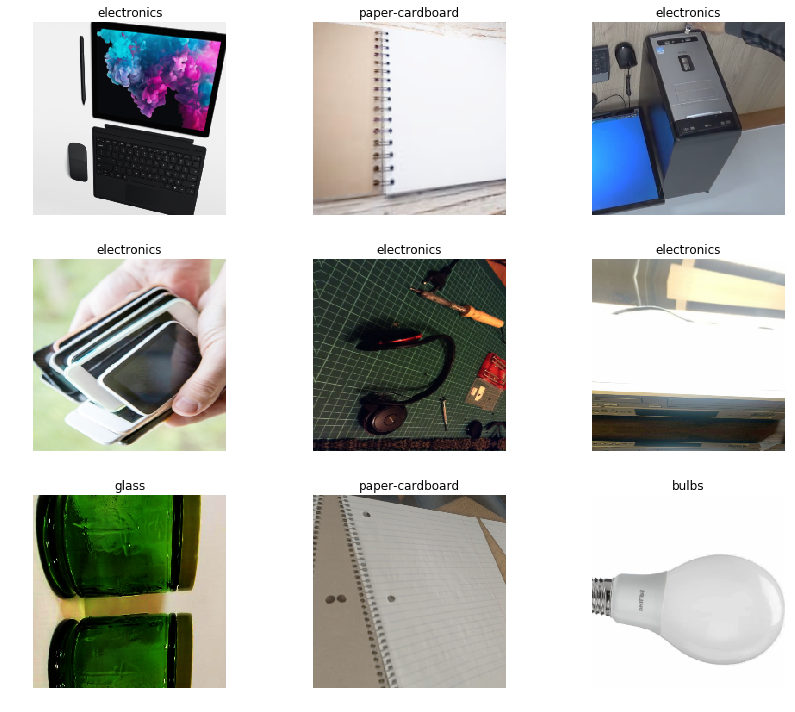

In [12]:
data.show_batch(rows=3, figsize=(12,10))

In [14]:
assert len(data.classes) == data.c
data.classes

['batteries',
 'bulbs',
 'electronics',
 'glass',
 'metals',
 'paper-cardboard',
 'plastics']

## Training: resnet50

In [15]:
from recycling_classification.ranger import Ranger

In [16]:
optar = partial(Ranger)

In [17]:
learn = cnn_learner(data, models.resnet50, metrics=accuracy, opt_func=optar)

In [18]:
learn.fit_one_cycle(4)

In [19]:
learn.save('stage-1')

In [20]:
learn.fit_one_cycle(1)

In [21]:
learn.save('stage-2')

In [22]:
learn.fit_one_cycle(1)

In [23]:
learn.save('stage-3')

In [24]:
learn.fit_one_cycle(1)

## Results

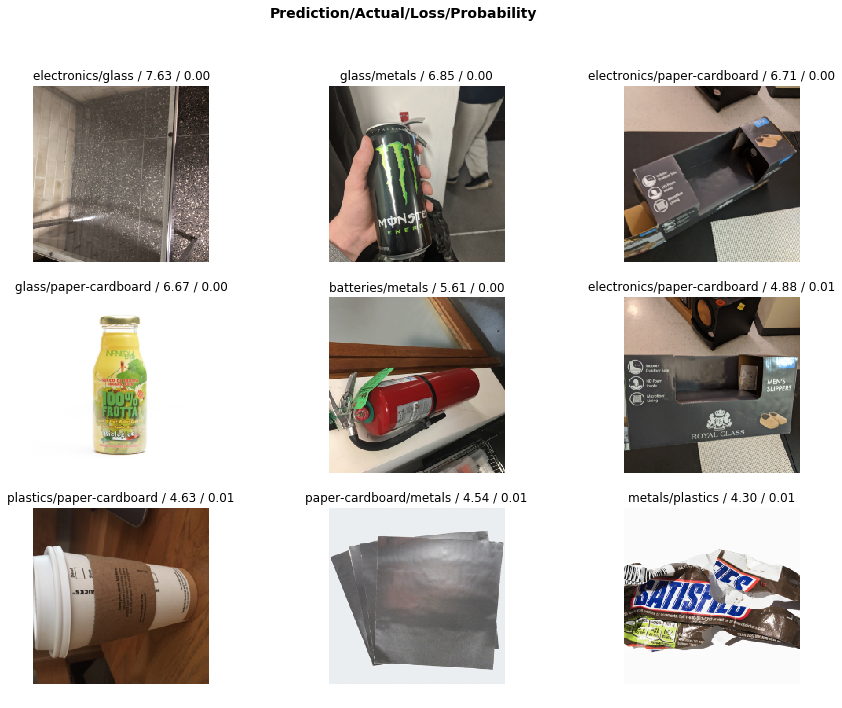

In [25]:
interp = ClassificationInterpretation.from_learner(learn)

losses, idxs = interp.top_losses()

assert len(data.valid_ds)==len(losses)==len(idxs)

interp.plot_top_losses(9, figsize=(15,11))

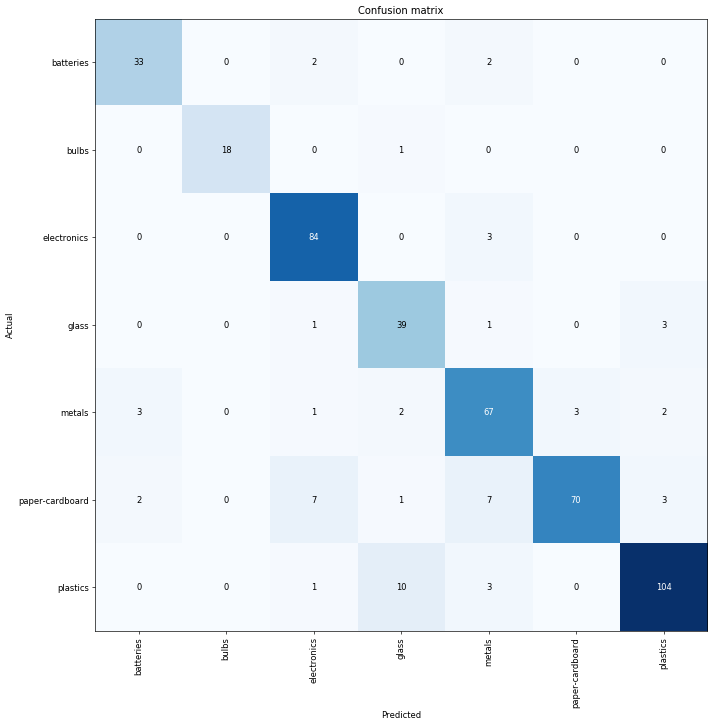

In [26]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [27]:
interp.most_confused(min_val=2)

[('plastics', 'glass', 10),
 ('paper-cardboard', 'electronics', 7),
 ('paper-cardboard', 'metals', 7),
 ('electronics', 'metals', 3),
 ('glass', 'plastics', 3),
 ('metals', 'batteries', 3),
 ('metals', 'paper-cardboard', 3),
 ('paper-cardboard', 'plastics', 3),
 ('plastics', 'metals', 3),
 ('batteries', 'electronics', 2),
 ('batteries', 'metals', 2),
 ('metals', 'glass', 2),
 ('metals', 'plastics', 2),
 ('paper-cardboard', 'batteries', 2)]

## Unfreezing, fine-tuning, and learning rates

In [28]:
learn.load('stage-3');

set state called


In [29]:
learn.lr_find()

set state called
LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.32E-06
Min loss divided by 10: 3.98E-03


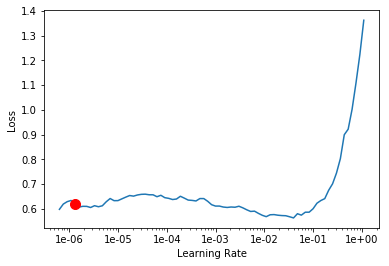

In [30]:
learn.recorder.plot(suggestion=True)

In [31]:
learn.unfreeze()
learn.fit_one_cycle(1, max_lr=slice(1e-5, 1e-2))

In [32]:
learn.save('unfrozen-stage-1')

In [33]:
learn.fit_one_cycle(1, max_lr=slice(1e-5, 1e-3))

In [34]:
learn.save('unfrozen-stage-2')

In [35]:
learn.fit_one_cycle(1, max_lr=slice(1e-5, 1e-3))

In [36]:
learn.save('unfrozen-stage-3')

In [37]:
learn.fit_one_cycle(1, max_lr=slice(1e-5, 1e-3))

In [38]:
learn.save('unfrozen-stage-4')

In [39]:
learn.fit_one_cycle(1, max_lr=slice(1e-5, 1e-3))

In [40]:
learn.save('unfrozen-stage-5')

In [41]:
learn.fit_one_cycle(1, max_lr=slice(1e-5, 1e-3))

In [42]:
learn.save('unfrozen-stage-6')

In [43]:
learn.fit_one_cycle(1, max_lr=slice(1e-5, 1e-3))

In [44]:
learn.load('unfrozen-stage-6');

set state called


## Prediction Time? 

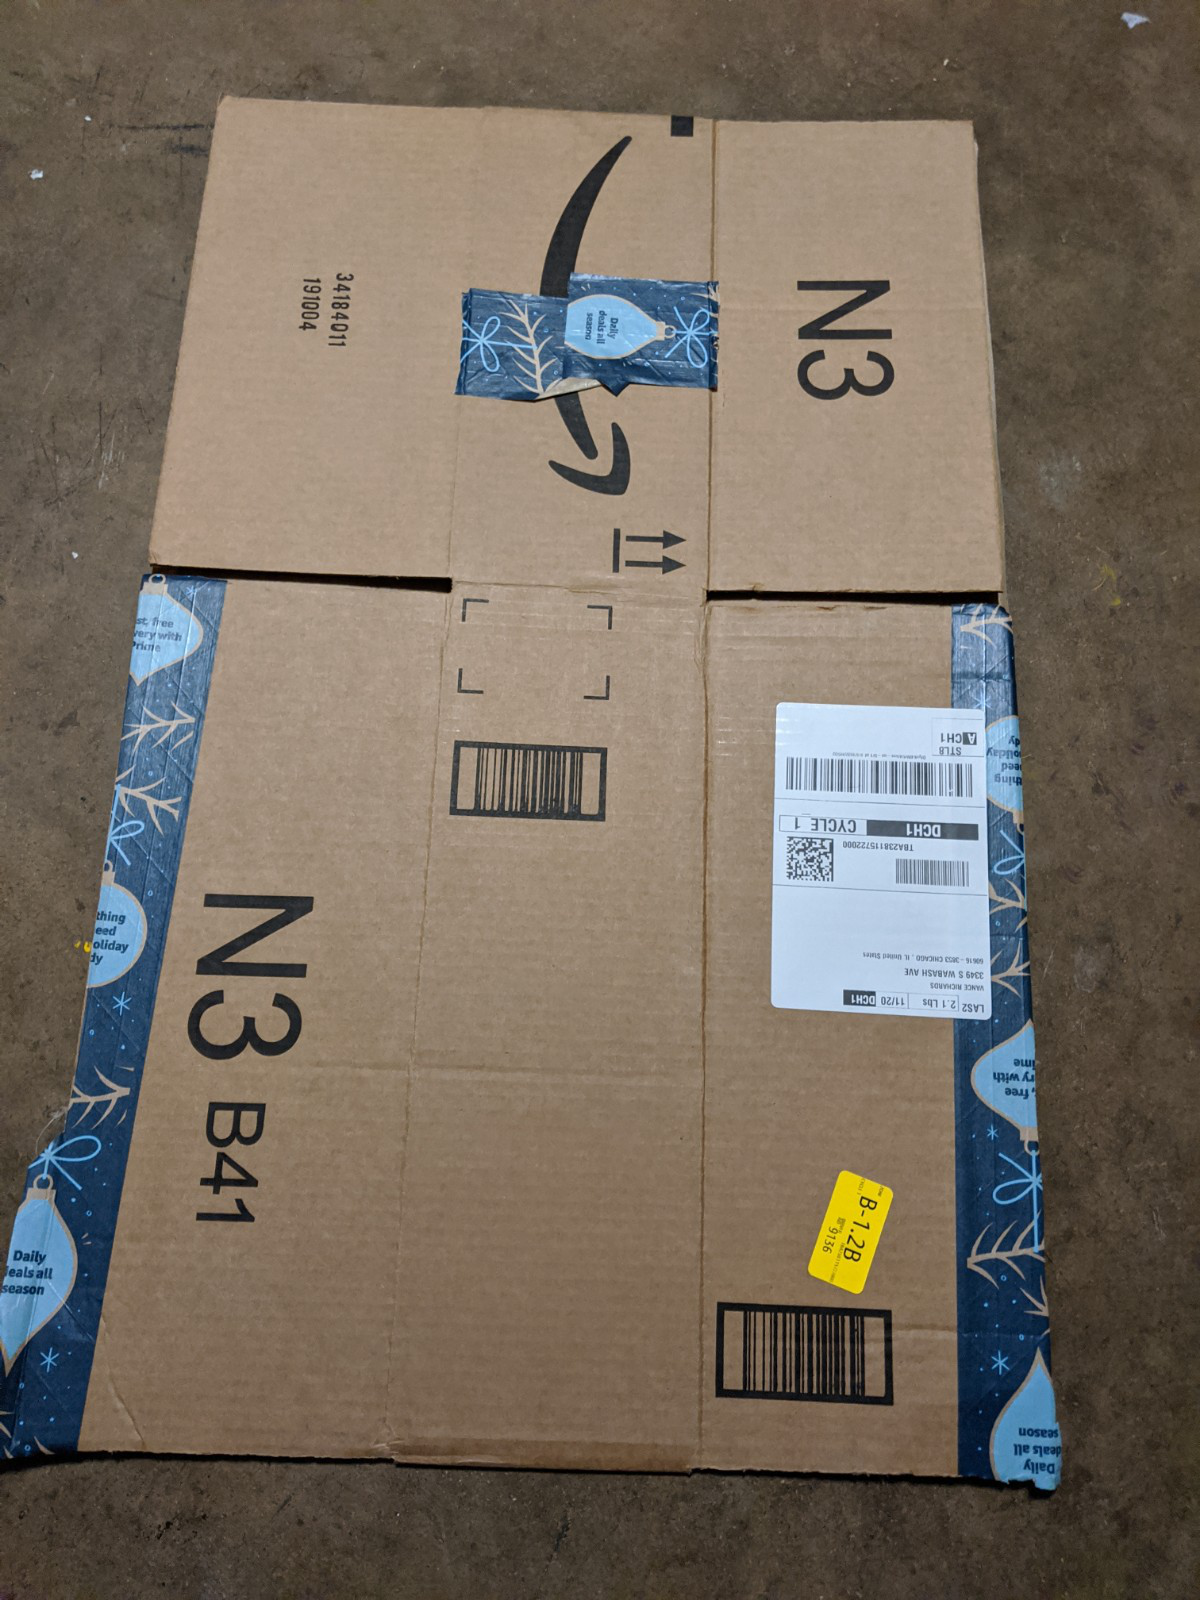

('paper-cardboard', 0.999783456325531)

In [46]:
test_image = im.open_image('/home/ubuntu/images/paper-cardboard-2.jpg')
display(test_image)

pred_class, _, pred_probs = learn.predict(test_image)
pred_class.obj, max(pred_probs.tolist())

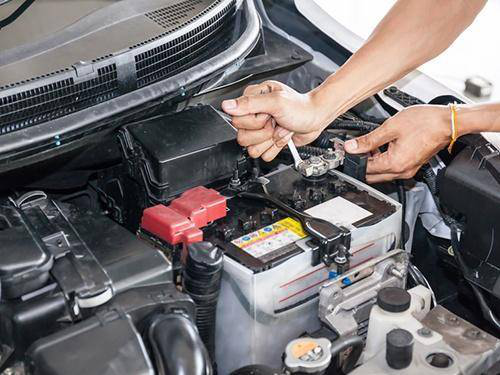

('batteries', 0.9754787683486938)

In [47]:
url = 'https://www.theflyer.com/uploads/image/205186801_205186900/automotive-battery-delivery-and-installation-service-we-replace-batteries-on-the-spot-205186880_c2747deefa5268fc_858X617.jpg'

response = requests.get(url)
image_from_interwebs = im.open_image(BytesIO(response.content))
display(image_from_interwebs)

pred_class, _, pred_probs = learn.predict(image_from_interwebs)
pred_class.obj, max(pred_probs.tolist())

Enter image URL: https://cdn.shopify.com/s/files/1/0102/3472/products/paper-towels-plain_0669f160-aed5-4d49-847c-ca9617327128_1024x1024.jpg?v=1450824133
--------------
Image:


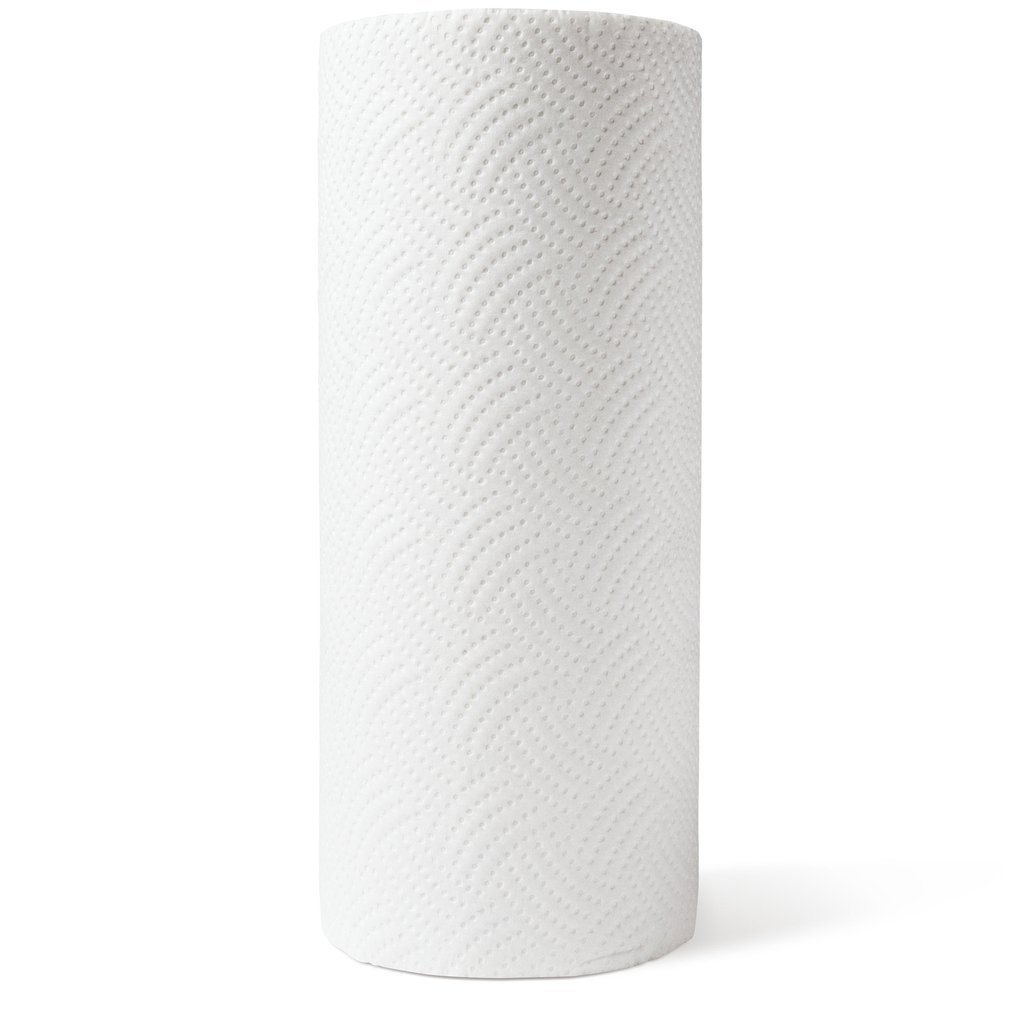

--------------
Predicted Class:         metals
Predicted Probability:   0.9577525854110718
Time to make prediction: 0.04657s


In [73]:
## INTERACTIVE MODE
url = input('Enter image URL: ')

response = requests.get(url)
image_from_interwebs = im.open_image(BytesIO(response.content))
print('--------------')
print('Image:')
display(image_from_interwebs)
print('--------------')
start_time = time.time()
pred_class, _, pred_probs = learn.predict(image_from_interwebs)
pred_class.obj, max(pred_probs.tolist())
print(f'Predicted Class:         {pred_class.obj}')
print(f'Predicted Probability:   {max(pred_probs.tolist())}')
print(f'Time to make prediction: {round(time.time() - start_time, 5)}s')

## Save Model Time 

In [39]:
learn.export('/home/ubuntu/model_1125_.pkl')

## Model to and from S3 

In [6]:
learner_2 = load_learner('/home/ubuntu/recycling_classification/data', file='model.pkl')

In [7]:
cd /home/ubuntu/recycling_classification/

/home/ubuntu/recycling_classification


In [40]:
from recycling_classification.s3_helper import model_from_s3, model_to_s3

In [41]:
model_to_s3(learn, s3_path='s3://recycling-classification/model_1112_0357.pkl')

Saved model to: s3://recycling-classification/model_1112_0357.pkl


In [19]:
learner_3 = model_from_s3(s3_path='s3://recycling-classification/test_learner_upload.pkl')

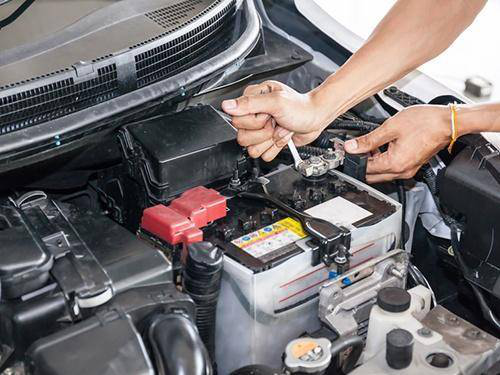

('batteries', 0.9976546168327332)

In [21]:
url = 'https://www.theflyer.com/uploads/image/205186801_205186900/automotive-battery-delivery-and-installation-service-we-replace-batteries-on-the-spot-205186880_c2747deefa5268fc_858X617.jpg'

response = requests.get(url)
image_from_interwebs = im.open_image(BytesIO(response.content))
display(image_from_interwebs)

pred_class, _, pred_probs = learner_3.predict(image_from_interwebs)
pred_class.obj, max(pred_probs.tolist())

----- 